# **Customer Segmentation Using Machine Learning**

### **Project Overview**
This project focuses on customer segmentation using clustering techniques to identify distinct groups of customers based on purchasing behavior. The goal is to enable targeted marketing strategies and improve campaign effectiveness while reducing marketing costs.

---

### **Setup and Library Installation**
We first install the necessary Python libraries for data analysis, clustering, and visualization. These libraries will allow us to clean the dataset, perform clustering, and interpret the results effectively.


In [3]:
# Install required libraries
!pip install pandas numpy scikit-learn matplotlib seaborn


---

### **Dataset Description**
The dataset used is the Online Retail Dataset from the UCI Machine Learning Repository. This dataset contains transactional data from an online retail store, which is ideal for customer segmentation tasks.

Key Features of the Dataset:
- **InvoiceNo**: Unique invoice identifier
- **StockCode**: Product identifier
- **Description**: Product description
- **Quantity**: Number of products purchased
- **InvoiceDate**: Date and time of transaction
- **UnitPrice**: Price per unit
- **CustomerID**: Unique customer identifier
- **Country**: Customer's country

We will load this dataset directly from the UCI repository.

In [4]:
import pandas as pd

# Dataset URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"

# Load the dataset into a DataFrame
df = pd.read_excel(url)

# Display the first few rows
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


---

### **Data Cleaning**
Before clustering, we need to clean the dataset by removing missing values and duplicates. This ensures that our analysis is accurate and free from incomplete or redundant data.

In [5]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Drop rows with missing values
df.dropna(inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

# Preview cleaned data
print("Cleaned dataset preview:")
df.head()


Missing values per column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
Cleaned dataset preview:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


---

### **Feature Engineering**
Features are extracted to capture key aspects of customer behavior, such as:
- **Recency**: Days since the customer's last purchase.
- **Frequency**: Total number of purchases by the customer.
- **Monetary**: Total amount spent by the customer.

These metrics will serve as the input features for our clustering model.

In [7]:
from datetime import datetime

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Define the reference date
reference_date = datetime(2011, 12, 10)  # Dataset end date

# Create RFM features
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'Quantity': lambda x: (x * df.loc[x.index, 'UnitPrice']).sum()  # Monetary
})

# Rename columns correctly
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Preview RFM table
rfm.head()



,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,18,73,1757.55
12350.0,310,17,334.40


---

### **Scaling the Data**
The RFM features have different scales (e.g., Monetary values are much larger than Recency or Frequency). To ensure all features contribute equally to clustering, we scale the data using StandardScaler.

In [9]:
from sklearn.preprocessing import StandardScaler

# Scale the RFM features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Optionally convert scaled data to a DataFrame for clarity
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

# Preview the scaled data
rfm_scaled_df.head()


,Recency,Frequency,Monetary
0,2.316568,-0.392056,-0.230420
1,-0.889050,0.393293,0.294055
2,-0.164560,-0.265527,-0.011717
3,-0.730258,-0.082279,-0.016547
4,2.167700,-0.326610,-0.189727


### **Determining Opitmal Clusters**
The Elbow Method is used to determine the optimal number of clusters by plotting the sum of squared distances (inertia) between points and their cluster centers. The "elbow point" in the plot indicates the ideal number of clusters.

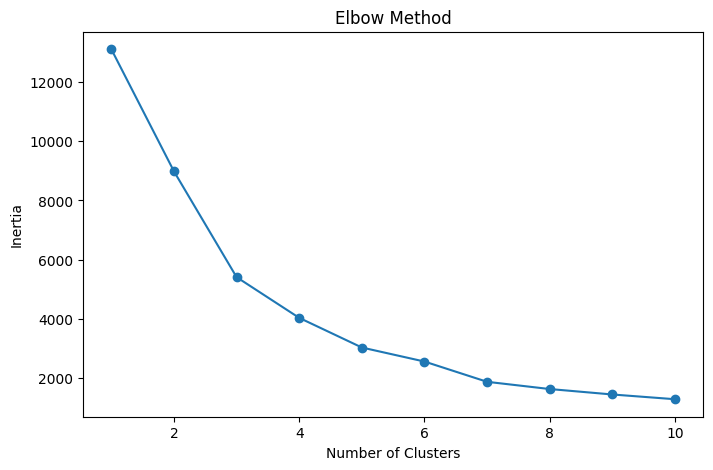

In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate distortions for 1 to 10 clusters
distortions = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    distortions.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()



---

### **Applying K-Means**
Using the number of clusters determined from the Elbow Method, we apply the K-Means clustering algorithm to segment the customers.


In [20]:
# Apply K-Means clustering with the optimal number of clusters
optimal_clusters = 3  # Based on the Elbow Method
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Preview the data with assigned cluster labels
rfm.head()




,Recency,Frequency,Monetary,Cluster,Recency_Scaled,Frequency_Scaled,Monetary_Scaled
CustomerID,,,,,,,
12346.0,325,2,0.00,1,2.316568,-0.392056,-0.230420
12347.0,2,182,4310.00,0,-0.889050,0.393293,0.294055
12348.0,75,31,1797.24,0,-0.164560,-0.265527,-0.011717
12349.0,18,73,1757.55,0,-0.730258,-0.082279,-0.016547
12350.0,310,17,334.40,1,2.167700,-0.326610,-0.189727


---

### **Visualizing Clusters**
We use a scatter plot to visualize the clusters and identify patterns in customer behavior. In this case, we plot the Recency vs. Monetary values, with clusters represented by different colors.


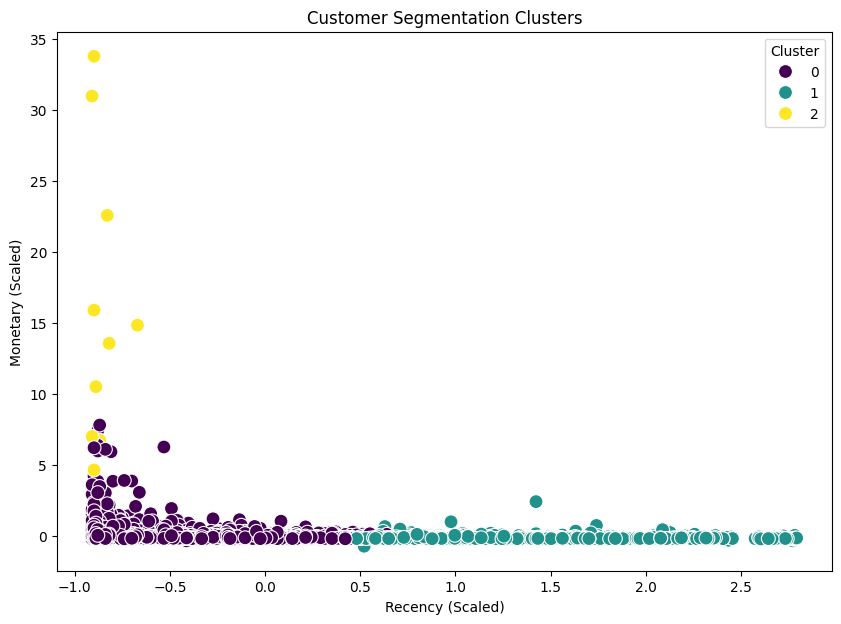

In [21]:
import seaborn as sns

# Add scaled features to the RFM DataFrame for plotting
rfm['Recency_Scaled'] = rfm_scaled[:, 0]
rfm['Frequency_Scaled'] = rfm_scaled[:, 1]
rfm['Monetary_Scaled'] = rfm_scaled[:, 2]

# Scatter plot for Recency vs Monetary
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=rfm['Recency_Scaled'],
    y=rfm['Monetary_Scaled'],
    hue=rfm['Cluster'],
    palette='viridis',
    s=100
)
plt.title('Customer Segmentation Clusters')
plt.xlabel('Recency (Scaled)')
plt.ylabel('Monetary (Scaled)')
plt.legend(title='Cluster')
plt.show()



---
### **Cluster Analysis**
We calculate the average Recency, Frequency, and Monetary values for each cluster to understand their characteristics. These insights help us define marketing strategies for each segment.


In [16]:
# Analyze the characteristics of each cluster
cluster_analysis = rfm.groupby('Cluster').mean()

# Display the cluster analysis
cluster_analysis


,Recency,Frequency,Monetary,Recency_Scaled,Frequency_Scaled,Monetary_Scaled
Cluster,,,,,,
0,39.696105,103.576817,1946.578719,-0.514934,0.051129,0.006455
1,246.489536,27.365787,462.193404,1.537390,-0.281384,-0.174176
2,4.333333,2813.750000,118564.639167,-0.865893,11.875756,14.197441


---
### **Validation**
The Silhouette Score measures the quality of clustering. A higher score indicates well-defined clusters.

In [22]:
from sklearn.metrics import silhouette_score

# Calculate the Silhouette Score
silhouette_avg = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')


Silhouette Score: 0.6004173528305708


---

### **Conclusion**
The clustering process successfully segmented customers into distinct groups based on their purchasing behavior. The insights gained from this analysis can guide:
- **Marketing Strategies**: Develop targeted campaigns for each customer segment.
- **Customer Retention**: Focus efforts on retaining high-value customers.
- **Resource Optimization**: Allocate resources effectively based on customer value.


### **Key Findings**
Based on the clustering analysis, we identified three distinct customer segments:

- **Cluster 0**: High-Value Loyal Customers
  - These customers purchase frequently and spend heavily, contributing significantly to revenue. Prioritize them for loyalty programs and exclusive offers to maintain their engagement.

- **Cluster 1**: Low-Value Infrequent Buyers
  - These are inactive customers with low spending and engagement. Re-engagement strategies, such as personalized discounts or special promotions, could help reactivate them.

- **Cluster 2**: Moderate-Value Occasional Buyers
  - This segment consists of occasional purchasers with average spending. They represent a growth opportunity and could be nurtured into becoming high-value customers with targeted marketing efforts.

